<img src="https://imgs.search.brave.com/J6D4toInIozipgRabyeqg22NqJ4zmhQMjnOoOgWXjeQ/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9tYXVj/aGVyLmhvbWUuaGRt/LXN0dXR0Z2FydC5k/ZS9QaWNzL3Zpc2lv/blRyYW5zZm9ybWVy/T3ZlcnZpZXcucG5n">

## Import libraires

In [25]:
import torch
from torch import nn
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

## Define the transformation

In [26]:
# Transformation for PIL to tensor format
transform = transforms.Compose(
    [transforms.ToTensor()]
)

## Download the data

In [27]:
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = MNIST(root='./data', train=False, transform=transform, download=False)

## Define the parameters

In [28]:
num_classes = 10
batch_size = 64
num_channels = 1
img_size = 28
patch_size = 7
num_patches = (img_size // patch_size) ** 2
embedding_dim = 64
attention_heads = 4
transformer_blocks = 4
mlp_hidden_nodes = 128
learning_rate = 0.001
epochs = 5

## Define the dataloader

In [29]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Part 1: Patch embedding

In [30]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)

        return x

In [31]:
# Sample a data point from the train_loader
data_point, label = next(iter(train_loader))
print("Shape of data point:", data_point.shape)

patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)
patch_embed_output = patch_embed(data_point)
print(patch_embed(data_point).shape)

patch_embed_output_flatten = patch_embed_output.flatten(2)
print(patch_embed_output_flatten.shape)

patch_embed_output_flatten_transpose = patch_embed_output_flatten.transpose(1, 2)
print(patch_embed_output_flatten_transpose.shape)

Shape of data point: torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 4, 4])
torch.Size([64, 64, 16])
torch.Size([64, 16, 64])


## Part 2: Transformer encoder

In [32]:
class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=attention_heads, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_hidden_nodes),
            nn.GELU(),
            nn.Linear(mlp_hidden_nodes, embedding_dim)
        )

    def forward(self, x):
        residual1 = x
        x = self.layer_norm1(x)
        x = self.multihead_attention(query=x, key=x, value=x)[0]
        x = x + residual1

        residual2 = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = x + residual2

        return x

## Part 3: MLP head

In [33]:
class MLP_head(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.layer_norm1(x)
        x = self.mlp_head(x)

        return x

## Part 4: Vision Transformer

In [34]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))
        self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
        self.mlp_head = MLP_head()

    def forward(self, x):
        x = self.patch_embed(x)
        B = x.size(0)
        class_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((class_tokens, x), dim=1)
        x = x + self.position_embedding
        x = self.transformer_blocks(x)
        x = x[:, 0]
        x = self.mlp_head(x)

        return x

## Training

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [36]:
# Training
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0

    print(f'\nEpoch {epoch+1}')

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        accuracy = 100.0 * (correct / labels.size(0))

        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 ==0:
            print(f'Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%')

    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f'==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%')



Epoch 1
Batch   1: Loss = 2.4488, Accuracy = 6.25%
Batch 101: Loss = 0.4819, Accuracy = 84.38%
Batch 201: Loss = 0.3086, Accuracy = 90.62%
Batch 301: Loss = 0.2231, Accuracy = 93.75%
Batch 401: Loss = 0.1295, Accuracy = 96.88%
Batch 501: Loss = 0.2575, Accuracy = 95.31%
Batch 601: Loss = 0.1503, Accuracy = 93.75%
Batch 701: Loss = 0.1038, Accuracy = 96.88%
Batch 801: Loss = 0.2842, Accuracy = 93.75%
Batch 901: Loss = 0.2703, Accuracy = 89.06%
==> Epoch 1 Summary: Total Loss = 341.0230, Accuracy = 88.54%

Epoch 2
Batch   1: Loss = 0.0721, Accuracy = 98.44%
Batch 101: Loss = 0.0335, Accuracy = 98.44%
Batch 201: Loss = 0.0357, Accuracy = 100.00%
Batch 301: Loss = 0.1247, Accuracy = 93.75%
Batch 401: Loss = 0.2156, Accuracy = 95.31%
Batch 501: Loss = 0.1475, Accuracy = 93.75%
Batch 601: Loss = 0.0769, Accuracy = 98.44%
Batch 701: Loss = 0.1091, Accuracy = 96.88%
Batch 801: Loss = 0.2122, Accuracy = 95.31%
Batch 901: Loss = 0.0315, Accuracy = 100.00%
==> Epoch 2 Summary: Total Loss = 112.0

## Validation

In [37]:
# Validation
model.eval()
val_loss = 0
correct_val = 0
total_val = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct_val += (preds == labels).sum().item()
        total_val += labels.size(0)

val_acc = 100.0 * correct_val / total_val
avg_val_loss = val_loss / len(val_loader)

print(f'>> Validation: Loss = {avg_val_loss:.4f}, Accuracy = {val_acc:.2f}%')


>> Validation: Loss = 0.0719, Accuracy = 97.90%


## Plotting

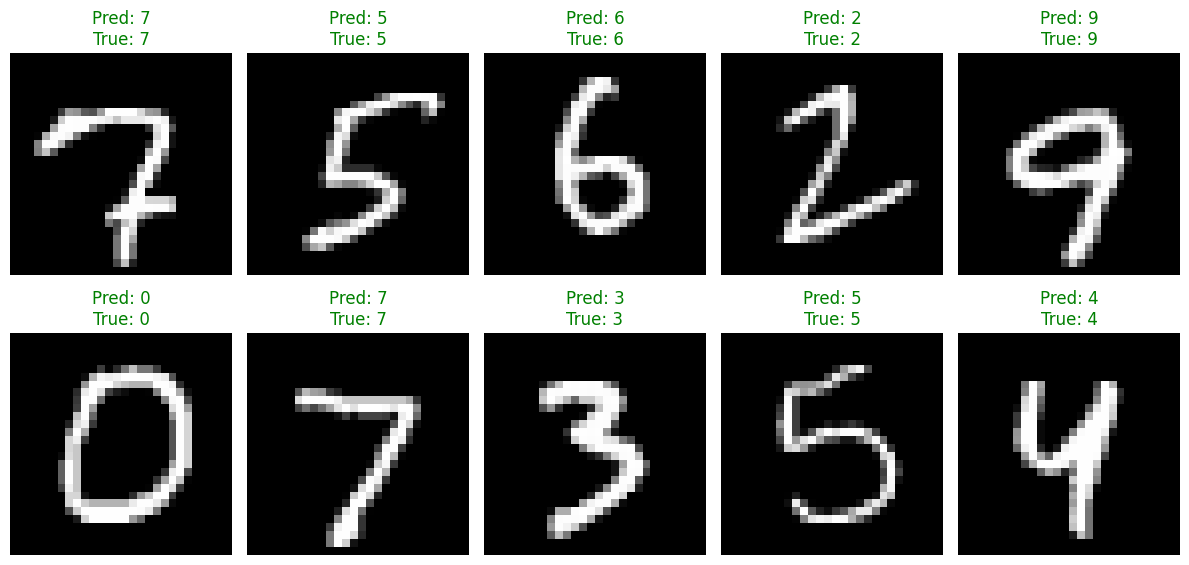

In [40]:
import matplotlib.pyplot as plt
import random

def show_random_predictions(model, dataloader, class_names=None, num_images=10):
    model.eval()
    images_shown = 0

    # grab one big batch so we can pick random samples from it
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    # run through model
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)

    # randomly pick indices
    idxs = random.sample(range(len(images)), num_images)

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(idxs):
        img = images[idx].cpu().squeeze(0)  # MNIST-like (1, H, W)
        pred = preds[idx].item()
        true = labels[idx].item()

        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Pred: {pred}\nTrue: {true}",
                  color="green" if pred == true else "red")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_predictions(model, val_loader)
